## Setup

### Imports

In [1]:
# Supprress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# File Handling
import os
import shutil

# Essential Libraries for Data Analysis and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing and NLP
import re
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.phrases import Phrases, Phraser
import spacy
from wordcloud import WordCloud

# Machine Learning Frameworks and Utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_auc_score,
    precision_recall_curve,
    auc
)
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from nltk.util import ngrams

# Deep Learning Frameworks and Models
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import (
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    Bidirectional,
    LSTM,
    Dense,
    Dropout
)
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Scikit-learn Wrapper for Keras Models
from scikeras.wrappers import KerasClassifier

In [3]:
# Setting Random Seed
import random
import tensorflow as tf

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
image_path = "Confusion Matrix"

if not os.path.exists(image_path):
    os.makedirs(image_path)
    print(f"Folder '{image_path}' created.")
else:
    print(f"Folder '{image_path}' already exists.")

Folder 'Confusion Matrix' already exists.


### Helper Functions

In [5]:
def process_sentence(sentence):
    """
    Cleans a given sentence by:
    - Removing all special characters.
    - Stripping out extra whitespaces.
    - Converting the string to lowercase.

    Parameters:
    sentence (str): The input sentence to process.

    Returns:
    str: A cleaned and processed version of the input sentence.
    
    Raises:
    ValueError: If the input is not a string or cannot be converted to a string.
    """
    try:
        return re.sub(r'[\\\\/:*`\'?";<>,.|]', '', str(sentence).lower().strip())
    except Exception as e:
        raise ValueError(f"An error occurred while processing the sentence: {e}")

In [6]:
def sent_to_words(sentences):
    """
    Converts a list of sentences into tokenized words using Gensim's simple_preprocess.

    Parameters:
    sentences (list of str): A list of sentences to process.

    Yields:
    list of str: A generator yielding tokenized words for each sentence.

    Raises:
    ValueError: If the input is not a list of strings or contains invalid data types.
    """
    try:
        for sentence in sentences:
            yield simple_preprocess(sentence, deacc=False)
    except Exception as e:
        raise ValueError(f"An error occurred while processing sentences: {e}")

In [7]:
def remove_stopwords(texts):
    """
    Removes stopwords from a list of documents.

    Parameters:
    texts (list of str): A list of documents, where each document is a string.

    Returns:
    list of list of str: A nested list where each inner list contains words from a document with stopwords removed.

    Raises:
    ValueError: If the input is not a list of strings or contains invalid data types.
    """
    try:
        return [[word for word in simple_preprocess(str(doc)) if word not in STOPWORDS] for doc in texts]
    except Exception as e:
        raise ValueError(f"An error occurred while removing stopwords: {e}")

In [8]:
!python -m spacy download en_core_web_sm

def lemmatization(texts, allowed_posttags=["NOUN", "ADJ", "VERB", "ADV"]):
    """
    Lemmatizes a list of tokenized sentences, retaining only specified parts of speech (POS).

    Parameters:
    texts (list of list of str): A list where each element is a tokenized sentence (list of strings).
    allowed_posttags (list of str): A list of POS tags to retain (default includes "NOUN", "ADJ", "VERB", and "ADV").

    Returns:
    list of list of str: A nested list where each inner list contains lemmatized words from a sentence 
                         that match the allowed POS tags.

    Raises:
    ValueError: If the input texts are not structured as a list of tokenized sentences.
    RuntimeError: If there is an issue loading or using the spaCy NLP model.
    """
    try:
        texts_out = []
        nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])  # Load spaCy NLP model
        for sent in texts:
            doc = nlp(" ".join(sent))  # Process tokenized sentence with spaCy
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_posttags])
        return texts_out
    except ValueError as ve:
        raise ValueError(f"Invalid input data for lemmatization: {ve}")
    except Exception as e:
        raise RuntimeError(f"An error occurred during lemmatization: {e}")

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 3.3 MB/s eta 0:00:04
     ------ --------------------------------- 2.1/12.8 MB 4.2 MB/s eta 0:00:03
     --------- ------------------------------ 2.9/12.8 MB 4.1 MB/s eta 0:00:03
     ------------- -------------------------- 4.2/12.8 MB 4.6 MB/s eta 0:00:02
     ----------------- ---------------------- 5.5/12.8 MB 4.9 MB/s eta 0:00:02
     -------------------- ------------------- 6.6/12.8 MB 5.0 MB/s eta 0:00:02
     ------------------------- -------------- 8.1/12.8 MB 5.2 MB/s eta 0:00:01
     ----------------------------- ---------- 9.4/12.8 MB 5.3 MB/s eta 0:00:01
     ---------------------------------- ----- 11.0/12.8 MB 5.6 MB/s eta 0:00:01
     ---------------------------------------  12.6/12.8 MB 5.7 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 5.7 M

In [9]:
def getWordCloud(hashtags):
    """
    Generates and saves a word cloud image based on a list of hashtags.

    Parameters:
    hashtags (list of str): A list of hashtags or words to include in the word cloud.

    Returns:
    None: Displays the word cloud image and saves it as a PNG file named 'wordcloud.png'.

    Raises:
    ValueError: If the input is not a list of strings.
    RuntimeError: If there is an issue generating or saving the word cloud image.
    """
    try:
        # Read the whole text
        text = ' '.join(hashtags)

        # Generate a word cloud image with specific parameters
        wordcloud = WordCloud(max_font_size=40, random_state=42).generate(text)
        
        # Display the generated image
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        
        # Save the word cloud image as a PNG with high resolution
        plt.savefig('wordcloud.png', dpi=500)
        plt.show()
    except ValueError as ve:
        raise ValueError(f"Invalid input for hashtags: {ve}")
    except Exception as e:
        raise RuntimeError(f"An error occurred while generating or saving the word cloud: {e}")

In [10]:
def evaluate_traditional_model(model, X_test, y_test, y_pred, model_name, category_labels=['Normal', 'Mood Disorders', 'Severe Conditions'], save_path=image_path):
    """
    Evaluates a multiclass classification model with ROC-AUC, PR-AUC, accuracy,
    classification report, and confusion matrix visualization.

    Parameters:
        model: Trained model with predict_proba method
        X_test: Test features
        y_test: True labels
        y_pred: Predicted labels
        category_labels: List of class labels (strings)
        save_path: Directory to save the confusion matrix plot (optional)
    """

    try:
        # === Check input dimensions ===
        if len(np.unique(y_test)) != len(category_labels):
            raise ValueError("Mismatch between number of classes in y_test and category_labels.")

        # === Get probability predictions ===
        try:
            y_pred_proba = model.predict_proba(X_test)
        except AttributeError:
            raise AttributeError("Model does not support predict_proba().")

        # === Binarize the true labels ===
        classes = np.unique(y_test)
        y_test_bin = label_binarize(y_test, classes=classes)

        # === ROC-AUC ===
        roc_auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr')
        print(f"\nROC-AUC (OVR): {roc_auc:.3f}")

        # === PR-AUC per class ===
        pr_aucs = []
        for i in range(len(classes)):
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
            pr_auc = auc(recall, precision)
            pr_aucs.append(pr_auc)
            print(f"PR-AUC for class '{category_labels[i]}': {pr_auc:.3f}")
        macro_pr_auc = np.mean(pr_aucs)
        print(f"Macro-average PR-AUC: {macro_pr_auc:.3f}")

        # === Accuracy and Classification Report ===
        accuracy = accuracy_score(y_test, y_pred)
        print(f"\nTest Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=category_labels))

        # === Confusion Matrix ===
        conf_matrix = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=category_labels)
        disp.plot(cmap='Greens')
        plt.xlabel("Predicted Label")
        plt.ylabel("Actual Label")
        plt.title(f"{model_name} Confusion Matrix")

        # === Save plot if needed ===
        if save_path:
            os.makedirs(save_path, exist_ok=True)
            file_path = os.path.join(save_path, f"{model_name} Confusion Matrix.png")
            plt.savefig(file_path, dpi=300)
            print(f"\nConfusion matrix saved to: {file_path}")

        plt.show()

    except Exception as e:
        print(f"\n[ERROR] Evaluation failed: {e}")


In [11]:
def evaluate_neural_model(model, history, X_test, y_test, model_name, category_labels=['Normal', 'Mood Disorders', 'Severe Conditions'], save_path=image_path):
    """
    Evaluates a neural network model with training history plots, ROC-AUC, PR-AUC, accuracy,
    classification report, and confusion matrix visualization.
    
    Parameters:
        model: Trained model with predict method (e.g., Keras model)
        history: Training history object (e.g., from model.fit())
        X_test: Test features
        y_test: True labels (one-hot encoded)
        model_name: Name of the model (for display and saving)
        category_labels: List of class labels (default: None)
        save_path: Directory to save the confusion matrix plot (optional)
    """
    try:
        # === Check and preprocess input ===
        if category_labels is None:
            category_labels = [f"Class {i}" for i in range(y_test.shape[1])] if len(y_test.shape) > 1 else np.unique(y_test)

        if len(np.unique(np.argmax(y_test, axis=1))) != len(category_labels):
            raise ValueError("Mismatch between number of classes in y_test and category_labels.")

        # Convert y_test to class indices for accuracy and confusion matrix
        y_test_classes = np.argmax(y_test, axis=1)

        # Predict class probabilities and classes
        y_pred_proba = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred_proba, axis=1)

        # === Test Accuracy ===
        accuracy = accuracy_score(y_test_classes, y_pred_classes)
        print(f"\nTest Accuracy: {accuracy:.4f}")

        # === Classification Report ===
        print("\nClassification Report:")
        print(classification_report(y_test_classes, y_pred_classes, target_names=category_labels))

        # === ROC-AUC ===
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr")
        print(f"\nROC-AUC (OVR): {roc_auc:.3f}")

        # === PR-AUC ===
        pr_aucs = []
        for i in range(len(category_labels)):
            precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_proba[:, i])
            pr_auc = auc(recall, precision)
            pr_aucs.append(pr_auc)
            print(f"PR-AUC for class '{category_labels[i]}': {pr_auc:.3f}")
        macro_pr_auc = np.mean(pr_aucs)
        print(f"Macro-average PR-AUC: {macro_pr_auc:.3f}")
        
        # === Confusion Matrix ===
        conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=category_labels)
        disp.plot(cmap='Greens')
        plt.title(f"{model_name} Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")

        # Save confusion matrix plot if save_path is provided
        if save_path:
            os.makedirs(save_path, exist_ok=True)
            file_path = os.path.join(save_path, f"{model_name} Confusion Matrix.png")
            plt.savefig(file_path, dpi=300)
            print(f"\nConfusion matrix saved to: {file_path}")

        plt.show()

        # === Plot Training and Validation Loss/Accuracy ===
        plt.figure(figsize=(12, 5))
        
        # Access history metrics correctly
        training_loss = history.history['loss']
        validation_loss = history.history['val_loss']
        training_accuracy = history.history['accuracy']
        validation_accuracy = history.history['val_accuracy']
        
        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(training_loss, label='Training Loss', color='blue')
        plt.plot(validation_loss, label='Validation Loss', color='orange')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        # Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(training_accuracy, label='Training Accuracy', color='blue')
        plt.plot(validation_accuracy, label='Validation Accuracy', color='orange')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()


    except Exception as e:
        print(f"\n[ERROR] Evaluation failed: {e}")

### Reading and Rebalancing the Data

In [12]:
df = pd.read_csv('./Combined Data.csv/Combined Data.csv')
df = df.drop(df.columns[0], axis=1)

# Dropping NaN values
df.dropna(inplace=True)

"""
- Neutral --> Normal
- Mood Disorders --> Anxietyy, Depression, Stress
- Severe Conditions --> Suicidal, Bipolar, Personality Disorder
"""

# Define categories
category_mapping = {
    'Normal': 'Normal',
    'Anxiety': 'Mood Disorders',
    'Depression': 'Mood Disorders',
    'Stress': 'Mood Disorders',
    'Suicidal': 'Severe Conditions',
    'Bipolar': 'Severe Conditions',
    'Personality disorder': 'Severe Conditions'
}

# Apply mapping
df['category'] = df['status'].map(category_mapping)

# Define target sample size
sample_size = 14506

# Perform undersampling
df = df.groupby('category').apply(lambda x: x.sample(sample_size, random_state=42)).reset_index(drop=True)

# Shuffling the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(df['category'].value_counts())  # Check the distribution

category
Mood Disorders       14506
Severe Conditions    14506
Normal               14506
Name: count, dtype: int64


In [13]:
# X and y for deep learning models
X1 = df['statement'].astype(str).values
y1 = df['category']

In [14]:
# X and y for traditional models
X2 = df['statement'].apply(process_sentence)
y2 = df['category']

#### Text Preprocessing: Tokenize, Stopword

In [15]:
# 1. Tokenize text using gensim's simple_preprocess
data_words = [simple_preprocess(doc, deacc=True) for doc in X2]  # deacc=True removes punctuation

In [16]:
# 2. Remove stopwords
data_words_nostops = [[word for word in doc if word not in STOPWORDS] for doc in data_words]

#### Word Cloud

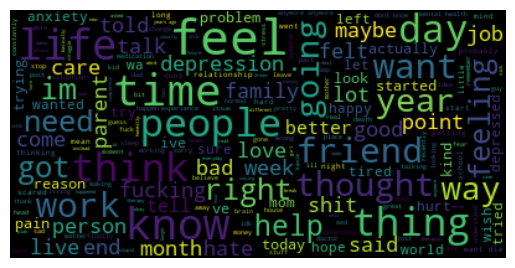

In [17]:
all_words = []
for doc in data_words_nostops:
    all_words.extend(doc)
    
getWordCloud(all_words)

#### Lemmatize

In [18]:
# 3. Lemmatize
data_words_lemmatized = lemmatization(data_words_nostops)

#### Generate the bigrams and trigrams

In [19]:
# 4. Create bigram and trigram models
bigram = Phrases(data_words_lemmatized, min_count=5, threshold=20)
bigram_mod = Phraser(bigram)

trigram = Phrases(bigram_mod[data_words_lemmatized], threshold=50)
trigram_mod = Phraser(trigram)

In [20]:
# 5. Apply models
data_words_bigrams = [bigram_mod[doc] for doc in data_words_lemmatized]
data_words_trigrams = [trigram_mod[bigram_mod[doc]] for doc in data_words_lemmatized]

In [21]:
# 6. Collect bigrams and trigrams
bigrams = []
trigrams = []

for doc in data_words_bigrams:
    bigrams.extend([word for word in doc if '_' in word])

for doc in data_words_trigrams:
    trigrams.extend([word for word in doc if word.count('_') >= 2])

In [22]:
# 7. Print output
print(f"Total Bigrams Found: {len(bigrams)}")
print("Sample Bigrams:", bigrams[:10])

print(f"\nTotal Trigrams Found: {len(trigrams)}")
print("Sample Trigrams:", trigrams[:10])

Total Bigrams Found: 50451
Sample Bigrams: ['title_say', 'self_harm', 'sexually_assault', 'mental_breakdown', 'high_school', 'thank_listen', 'throwaway_account', 'make_sense', 'social_anxiety', 'primary_school']

Total Trigrams Found: 1176
Sample Trigrams: ['relapse_self_harm', 'mental_health_professional', 'borderline_personality_disorder', 'generalize_anxiety_disorder', 'swollen_lymph_node', 'white_blood_cell', 'play_video_game', 'minimum_wage_job', 'borderline_personality_disorder', 'low_self_esteem']


### Pre-processed inputs and outputs

In [23]:
strings = []
for l in data_words_lemmatized:
    t = " ".join(l)
    strings.append(t)
    
strings[:5]

['title say start take med start today want end work making feel stable reason stop take hate feel stable feel normal feel right feel wrong go want well',
 'good friend change start date hurt urself priority anymore travel come yesterday call tell say see girl hasn see day tell haven see day come say want spend night apologize honestly think hear word sorry tell day',
 'hate shaving',
 'kiss money upset',
 'student usc']

In [24]:
# X and y
X = strings
y = df['category'].mapy = df["category"].map({"Severe Conditions": 2, "Mood Disorders": 1, "Normal": 0}).to_numpy()

# Check length of X and y
len(X), len(y)

(43518, 43518)

## Traditional Models

### Pre-processing

In [25]:
pipeline = Pipeline(
    [
        ("vect", CountVectorizer(max_features=5000, ngram_range=(1, 3))),
        ("tfidf", TfidfTransformer())
    ]
)

In [26]:
x_train_str, x_test_str, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
X_train = pipeline.fit_transform(x_train_str)
X_test = pipeline.transform(x_test_str)

# Check data for balancing
print(f"{sum(y_train == 0)} Normal")
print(f"{sum(y_train == 1)} Mood Disorders")
print(f"{sum(y_train == 2)} Severe Conditions")

10159 Normal
10091 Mood Disorders
10212 Severe Conditions


### Naive Bayes Classifier
A probabilistic model that works well for text classification, especially when features are based on word frequency (e.g., TF-IDF).  

In [28]:
param_grid = {
    'alpha': [0.1, 0.15, 0.2, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

grid_search_nb = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search_nb.fit(X_train, y_train)

print("Best Parameters for Naive Bayes: ", grid_search_nb.best_params_)
print("Best Cross-Validation Accuracy: ", grid_search_nb.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for Naive Bayes:  {'alpha': 0.1, 'fit_prior': False}
Best Cross-Validation Accuracy:  0.7105902557200771


In [29]:
best_model = grid_search_nb.best_estimator_

# Display the best model's hyperparameters
print("Best Model: ", best_model)

Best Model:  MultinomialNB(alpha=0.1, fit_prior=False)


In [30]:
# Make predictions
y_pred = best_model.predict(X_test)


ROC-AUC (OVR): 0.877
PR-AUC for class 'Normal': 0.867
PR-AUC for class 'Mood Disorders': 0.756
PR-AUC for class 'Severe Conditions': 0.729
Macro-average PR-AUC: 0.784

Test Accuracy: 0.7158

Classification Report:
                   precision    recall  f1-score   support

           Normal       0.86      0.78      0.82      4347
   Mood Disorders       0.67      0.64      0.66      4415
Severe Conditions       0.64      0.72      0.68      4294

         accuracy                           0.72     13056
        macro avg       0.72      0.72      0.72     13056
     weighted avg       0.72      0.72      0.72     13056


Confusion matrix saved to: Confusion Matrix\Naive Bayes Confusion Matrix.png


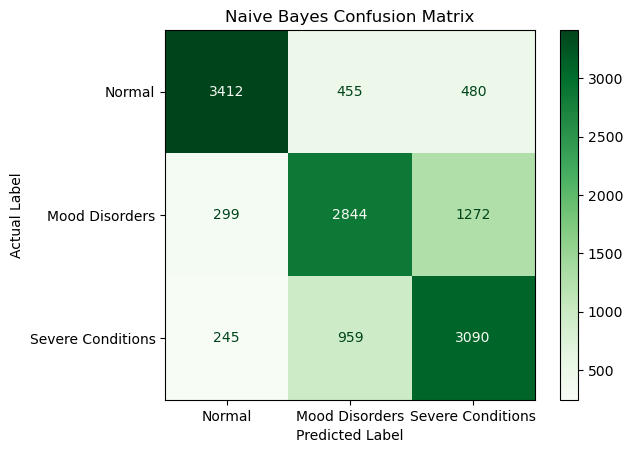

In [31]:
evaluate_traditional_model(
    model=best_model,
    X_test=X_test,
    y_test=y_test,
    y_pred=y_pred,
    model_name='Naive Bayes'
)


### Decision Tree / Random Forest
Categorization with bag-of-words or TF-IDF representations.

In [32]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [33]:
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=2, scoring='accuracy', verbose=2)
grid_search_rf.fit(X_train, y_train)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [34]:
print("Best Parameters for Random Forest: ", grid_search_rf.best_params_)
print("Best Cross-Validation Accuracy: ", grid_search_rf.best_score_)

Best Parameters for Random Forest:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Accuracy:  0.711148315934607


In [35]:
best_model = grid_search_rf.best_estimator_

# Display the best model's hyperparameters
print("Best Model: ", best_model)

Best Model:  RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=200,
                       random_state=42)


In [36]:
# Make predictions
y_pred = best_model.predict(X_test)


ROC-AUC (OVR): 0.878
PR-AUC for class 'Normal': 0.916
PR-AUC for class 'Mood Disorders': 0.747
PR-AUC for class 'Severe Conditions': 0.698
Macro-average PR-AUC: 0.787

Test Accuracy: 0.7230

Classification Report:
                   precision    recall  f1-score   support

           Normal       0.74      0.95      0.83      4347
   Mood Disorders       0.74      0.59      0.65      4415
Severe Conditions       0.69      0.63      0.66      4294

         accuracy                           0.72     13056
        macro avg       0.72      0.72      0.71     13056
     weighted avg       0.72      0.72      0.71     13056


Confusion matrix saved to: Confusion Matrix\Random Forest Confusion Matrix.png


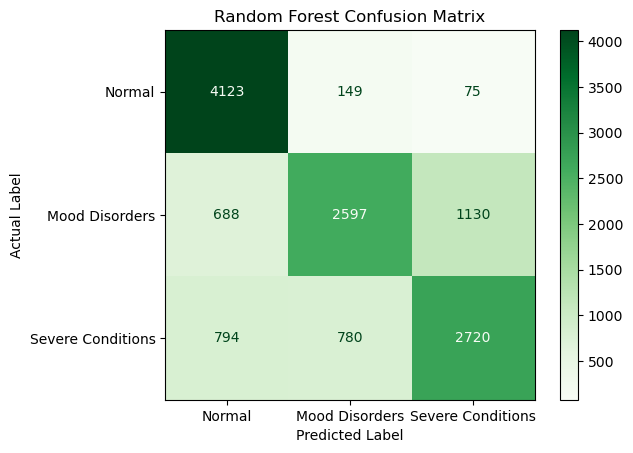

In [37]:
evaluate_traditional_model(
    model=best_model,
    X_test=X_test,
    y_test=y_test,
    y_pred=y_pred,
    model_name='Random Forest'
)

### Logistic Regression
Effective for binary/multi-class classification tasks and often used with word embeddings or TF-IDF features

In [38]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200]
}

In [39]:
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .............C=0.01, max_iter=100, solver=liblinear; total time=   0.1s
[CV] END .............C=0.01, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END .................C=0.01, max_iter=100, solver=lbfgs; total time=   0.1s
[CV] END .................C=0.01, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=100, solver=lbfgs; total time=   0.1s
[CV] END .............C=0.01, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, max_iter=200, solv

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='accuracy', verbose=2)

In [40]:
print("Best Parameters for Logistic Regression: ", grid_search_lr.best_params_)
print("Best Cross-Validation Accuracy: ", grid_search_lr.best_score_)

Best Parameters for Logistic Regression:  {'C': 1, 'max_iter': 200, 'solver': 'lbfgs'}
Best Cross-Validation Accuracy:  0.7616701037615795


In [41]:
best_model = grid_search_lr.best_estimator_

# Display the best model's hyperparameters
print("Best Model: ", best_model)

Best Model:  LogisticRegression(C=1, max_iter=200, random_state=42)


In [42]:
# Make predictions
y_pred = best_model.predict(X_test)


ROC-AUC (OVR): 0.909
PR-AUC for class 'Normal': 0.945
PR-AUC for class 'Mood Disorders': 0.796
PR-AUC for class 'Severe Conditions': 0.763
Macro-average PR-AUC: 0.835

Test Accuracy: 0.7655

Classification Report:
                   precision    recall  f1-score   support

           Normal       0.84      0.93      0.89      4347
   Mood Disorders       0.73      0.68      0.70      4415
Severe Conditions       0.71      0.69      0.70      4294

         accuracy                           0.77     13056
        macro avg       0.76      0.77      0.76     13056
     weighted avg       0.76      0.77      0.76     13056


Confusion matrix saved to: Confusion Matrix\Logistic Regression Confusion Matrix.png


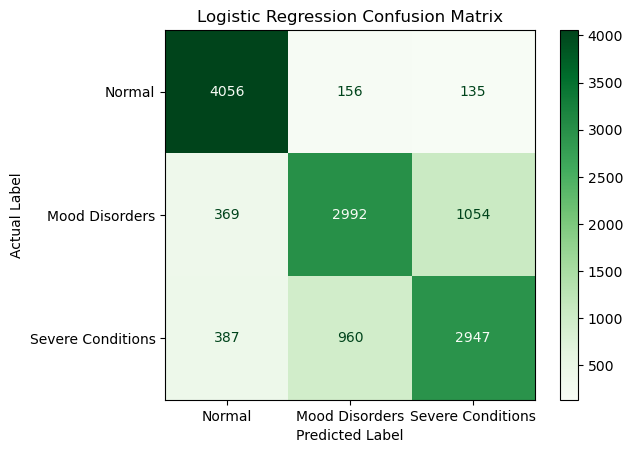

In [43]:
evaluate_traditional_model(
    model=best_model,
    X_test=X_test,
    y_test=y_test,
    y_pred=y_pred,
    model_name='Logistic Regression'
)

## Deep Learning Models

### Pre-processing

In [44]:
X = strings
y = y = df['category'].mapy = df["category"].map({"Severe Conditions": 2, "Mood Disorders": 1, "Normal": 0}).to_numpy()

In [45]:
# Function to add bigrams and trigrams to existing tokenized and lemmatized data
def add_ngrams(tokens_list, n=3):
    output = []
    for tokens in tokens_list:
        all_ngrams = []
        for i in range(1, n + 1):
            ngram_tokens = ['_'.join(ng) for ng in ngrams(tokens, i)]
            all_ngrams.extend(ngram_tokens)
        output.append(' '.join(all_ngrams))  # Join for tokenizer input
    return output

# Assume 'strings' is a list of tokenized and lemmatized lists (e.g., [['mental', 'health'], ['feeling', 'good'], ...])
X = add_ngrams(X, n=3)  # Generates unigrams + bigrams + trigrams as joined tokens


In [46]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)

In [47]:
# Tokenization
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=max_len)

In [48]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### BiLSTM
Bi-directional Long Short-Term Memory networks work well for sequential data, preserving context

In [49]:
model = Sequential(
    [
        Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(y.shape[1], activation='softmax', kernel_regularizer=l2(0.01))
    ]
)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                        

In [50]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
980/980 [==============================] - 27s 20ms/step - loss: 1.0298 - accuracy: 0.4935 - val_loss: 0.9326 - val_accuracy: 0.4920
Epoch 2/100
980/980 [==============================] - 20s 20ms/step - loss: 0.9499 - accuracy: 0.4896 - val_loss: 0.9379 - val_accuracy: 0.4899
Epoch 3/100
980/980 [==============================] - 20s 20ms/step - loss: 0.9483 - accuracy: 0.4936 - val_loss: 0.9412 - val_accuracy: 0.4986
Epoch 4/100
980/980 [==============================] - 19s 20ms/step - loss: 0.9474 - accuracy: 0.4927 - val_loss: 0.9270 - val_accuracy: 0.4980
Epoch 5/100
980/980 [==============================] - 20s 20ms/step - loss: 0.9386 - accuracy: 0.4992 - val_loss: 0.9274 - val_accuracy: 0.5032
Epoch 6/100
980/980 [==============================] - 20s 21ms/step - loss: 0.9391 - accuracy: 0.4979 - val_loss: 0.9153 - val_accuracy: 0.5043
Epoch 7/100
980/980 [==============================] - 20s 20ms/step - loss: 0.9330 - accuracy: 0.5045 - val_loss: 0.9144 - val_ac

272/272 [==============================] - 3s 8ms/step

Test Accuracy: 0.5601

Classification Report:
                   precision    recall  f1-score   support

           Normal       0.85      0.73      0.79      2883
   Mood Disorders       0.47      0.59      0.53      2992
Severe Conditions       0.40      0.35      0.37      2829

         accuracy                           0.56      8704
        macro avg       0.57      0.56      0.56      8704
     weighted avg       0.57      0.56      0.56      8704


ROC-AUC (OVR): 0.761
PR-AUC for class 'Normal': 0.842
PR-AUC for class 'Mood Disorders': 0.482
PR-AUC for class 'Severe Conditions': 0.466
Macro-average PR-AUC: 0.597

Confusion matrix saved to: Confusion Matrix\BiLSTM Confusion Matrix.png


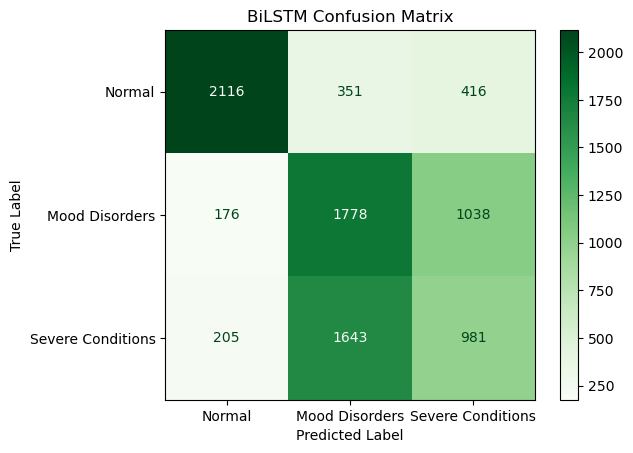

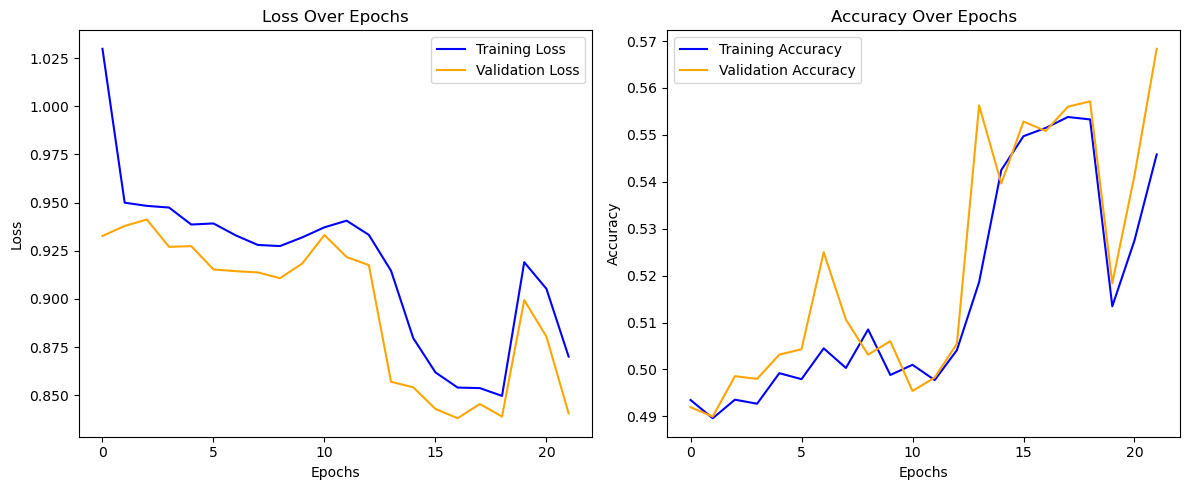

In [51]:
evaluate_neural_model(model=model, history=history, X_test=X_test, y_test=y_test, model_name='BiLSTM')

### CNN for Text Classification
Convolutional Neural Networks (CNNs) can capture local patterns in text, making them useful for short text classification.

In [52]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu'),  # Convolutional layer
    GlobalMaxPooling1D(),  # Reduces sequence dimension
    Dropout(0.5),  # Regularization
    Dense(64, activation='relu'),  # Fully connected layer
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')  # Output layer for multiclass classification
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                      

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
980/980 [==============================] - 14s 5ms/step - loss: 0.8730 - accuracy: 0.5505 - val_loss: 0.7755 - val_accuracy: 0.6206
Epoch 2/100
980/980 [==============================] - 5s 5ms/step - loss: 0.8054 - accuracy: 0.5975 - val_loss: 0.7487 - val_accuracy: 0.6295
Epoch 3/100
980/980 [==============================] - 5s 5ms/step - loss: 0.7867 - accuracy: 0.6063 - val_loss: 0.7463 - val_accuracy: 0.6289
Epoch 4/100
980/980 [==============================] - 5s 5ms/step - loss: 0.7794 - accuracy: 0.6131 - val_loss: 0.7384 - val_accuracy: 0.6356
Epoch 5/100
980/980 [==============================] - 5s 5ms/step - loss: 0.7721 - accuracy: 0.6164 - val_loss: 0.7282 - val_accuracy: 0.6413
Epoch 6/100
980/980 [==============================] - 5s 5ms/step - loss: 0.7653 - accuracy: 0.6222 - val_loss: 0.7225 - val_accuracy: 0.6424
Epoch 7/100
980/980 [==============================] - 5s 5ms/step - loss: 0.7595 - accuracy: 0.6229 - val_loss: 0.7329 - val_accuracy: 0.648

272/272 [==============================] - 0s 1ms/step

Test Accuracy: 0.6515

Classification Report:
                   precision    recall  f1-score   support

           Normal       0.87      0.78      0.82      2883
   Mood Disorders       0.56      0.59      0.57      2992
Severe Conditions       0.56      0.59      0.57      2829

         accuracy                           0.65      8704
        macro avg       0.66      0.65      0.66      8704
     weighted avg       0.66      0.65      0.66      8704


ROC-AUC (OVR): 0.838
PR-AUC for class 'Normal': 0.898
PR-AUC for class 'Mood Disorders': 0.646
PR-AUC for class 'Severe Conditions': 0.616
Macro-average PR-AUC: 0.720

Confusion matrix saved to: Confusion Matrix\CNN Confusion Matrix.png


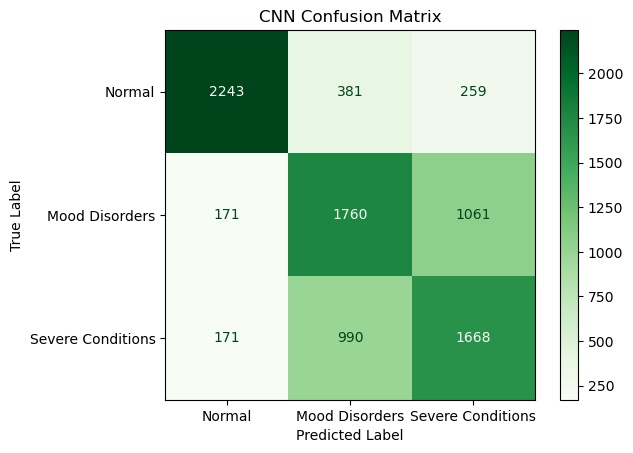

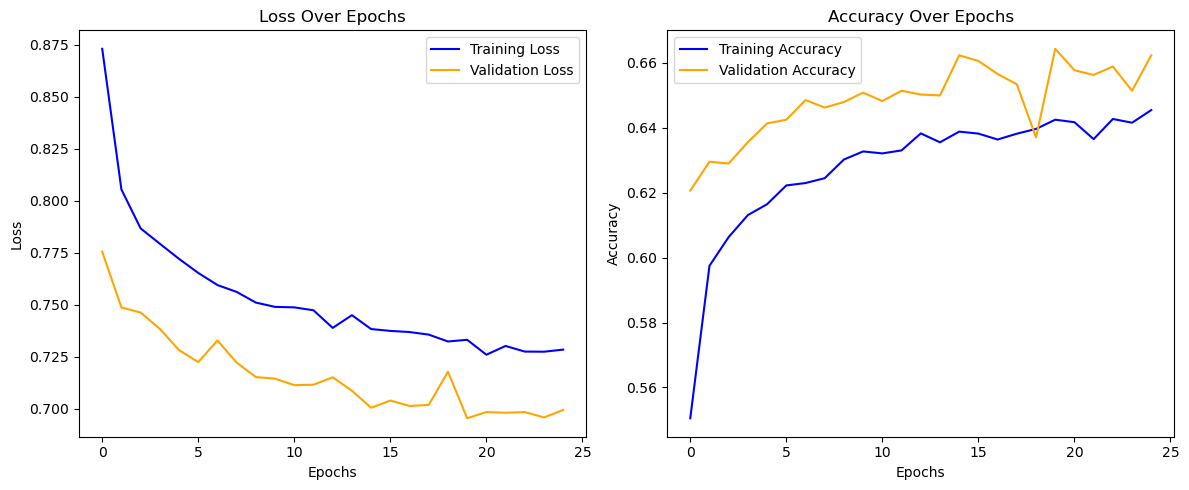

In [54]:
evaluate_neural_model(model=model, history=history, X_test=X_test, y_test=y_test, model_name='CNN')